In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003737771, 'queue_time': 0.236462564, 'total_time': 0.053737771}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-d1a7ddaa-9145-4d65-917d-e4376c53ba22-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

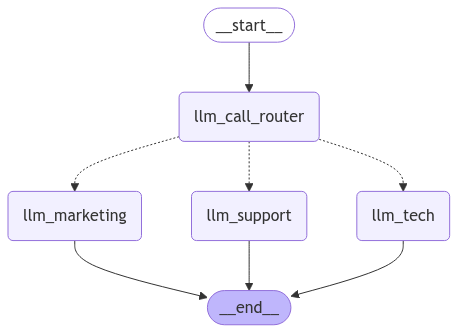

tech email
Subject: Urgent Assistance Needed: AWS IAM S3 Access Policy Issue

Dear [Support Team/IT Manager],

I hope this email finds you well.

I am writing to request your assistance in resolving an issue related to AWS IAM policies, specifically regarding access to S3 buckets.

**Issue Description:**
I'm encountering difficulties with the access policies set for a particular IAM user or role in accessing an S3 bucket. Despite having what I believe to be the correct permissions configured, the user is still unable to perform specific actions (e.g., list files, upload/download files, delete files) on the S3 bucket.

**Current Policy:**
Here is the policy currently attached to the IAM user/role:
```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "s3:ListBucket"
            ],
            "Resource": "arn:aws:s3:::[bucket-name]"
        },
        {
            "Effect": "Allow",
            "Action

In [22]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display



# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["support", "tech", "marketing"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_marketing(state: State):
    """Write a solution for marketing email"""

    result = llm.invoke("write in an email format" + state["input"])
    return {"output": result.content}


def llm_support(state: State):
    """Write a solution for support email"""

    print("LLM call 2 is called")

    result = llm.invoke("write in an email format" + state["input"])
    return {"output": result.content}


def llm_tech(state: State):
    """Write a solution for tech email"""

    result = llm.invoke("write in an email format" + state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to marketing, tech, or support based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "marketing":
        print("support email")
        return "llm_marketing"
    elif state["decision"] == "tech":
        print("tech email")
        return "llm_tech"
    elif state["decision"] == "support":
        print("support email")
        return "llm_support"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_marketing", llm_marketing)
router_builder.add_node("llm_tech", llm_tech)
router_builder.add_node("llm_support", llm_support)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_marketing": "llm_marketing",
        "llm_tech": "llm_tech",
        "llm_support": "llm_support",
    },
)
router_builder.add_edge("llm_marketing", END)
router_builder.add_edge("llm_tech", END)
router_builder.add_edge("llm_support", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "i need help in tech solution where i need to fix aws iam s3 issue with policy?"})
print(state["output"])